In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from random import choice

#draft class

In [13]:
class ProcessData:
    def __init__(self, data_path = 'wine_data.csv') -> None:
        self.df = pd.read_csv(data_path)
        self.df_arr = self.df.to_numpy()
        self.cols = list(self.df.columns)
        self.standardized_df = []
    
    # STANDARDIZE DATASET SUCH THAT MEAN WILL BE 0 AND STANDARD DEVIATION BE 1
    def standadardize_data(self):
        data_with_mean_0 = self.df_arr - self.df_arr.mean()
        data_with_std_1 = data_with_mean_0 / self.df_arr.std()
        standardized_data = data_with_std_1
        self.standardized_df = pd.DataFrame(standardized_data, columns = self.cols)

        # mean of each feature
        each_feature_mean = self.standardized_df.mean()
        for index, col in enumerate(self.cols):
            self.standardized_df[col] -= each_feature_mean[index]
        return self.standardized_df
        
    def compute_covariance_matrix(self, standardized_data):
        multiplied = pd.DataFrame()
        for col in self.cols:
            for j, COL in enumerate(self.cols):
                if j != len(self.cols):
                    multiplied[col + " " + self.cols[j]] = standardized_data[col] * standardized_data[self.cols[j]]
        
        sums = multiplied.sum()
        c = [i for i in range(0, len(sums), 13)]

        Covariance_matrix = []
        for i, index in enumerate(c):
            try:
                Covariance_matrix.append(list(sums[index:c[i+1]]))
            except IndexError: 
                Covariance_matrix.append(list(sums[index:]))

        covariance_df = pd.DataFrame(Covariance_matrix, columns=self.cols, index = self.cols)
        cov_matrix = np.array(Covariance_matrix)
        return cov_matrix
    
    def Compute_principal_components(self, cov_matrix):
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        eigenvalues_eugenvectors = {eigenvalue:eigenvectors[index] for index, eigenvalue in enumerate(eigenvalues)}
        eigenvalues.sort()
        
        # CHOOSE ONLY TOP 3 MAXIMUM EIGENVALUES AND GET THEIR EIGENVECTORS
        max_3_eigenvectors = eigenvalues[::-1][:3]
        eigenvectors_of_top_3_eigenvalues = np.array([eigenvalues_eugenvectors[eigen] for eigen in max_3_eigenvectors])

        eigenvectors_of_top_3_eigenvalues = np.transpose(eigenvectors_of_top_3_eigenvalues)
        reduced_dimension_wine_dataset = np.dot(self.df_arr, eigenvectors_of_top_3_eigenvalues)
        return reduced_dimension_wine_dataset, pd.DataFrame(reduced_dimension_wine_dataset, 
                                                            columns = ['Principal comp1', 'Principal comp2', 'Principal comp3'])
    
class Clustering:
    def __init__(self, dataframe, principal_components_array) -> None:
        # clusters = 2
        self.df = dataframe
        self.clusters_data = [[],[]]
        self.centroids = [[],[]]
        self.k1_initial_centroids = [choice(self.df[col]) for col in list(self.df.columns)]
        self.k2_initial_centroids = [choice(self.df[col]) for col in list(self.df.columns)]
        self.pca_array = principal_components_array

    def __Generate_clusters_phase1(self, k1_mean, k2_mean):
        # FIRST CLEAR THE CLUSTERS TO PREPARE THEM FOR RECEIVING NEW DATA
        self.clusters_data[0].clear()
        self.clusters_data[1].clear()
        
        # COMPUTE THE EUCLEDIAN DISTANCES
        variance1 = (self.pca_array - np.array(k1_mean)) ** 2
        variance2 = (self.pca_array - np.array(k2_mean)) ** 2
        eucledian_distances1 = np.sqrt(np.array([sum(row) for row in variance1]))
        eucledian_distances2 = np.sqrt(np.array([sum(row) for row in variance2]))
        combined = zip(eucledian_distances1, eucledian_distances2)

        for index, j in enumerate(combined):
            # CLASSIFY THE DATA INTO ITS CLUSTER BASED ON THE ONE WITH THE SMALLEST EUCLIDEAN DISTANCE
            self.clusters_data[j.index(min(j))].append(list(self.pca_array[index]))
            
        self.centroids[0].append(np.mean(np.array(self.clusters_data[0]), axis = 0))
        self.centroids[1].append(np.mean(np.array(self.clusters_data[1]), axis = 0))
        # return k1_mean, k2_mean
    
    def Optimize_clusters(self, epochs = 10):
        for i in range(epochs):
            if len(self.centroids[0]) > 0 and len(self.centroids[1]) > 0:
                self.__Generate_clusters_phase1(k1_mean=self.centroids[0][-1], k2_mean=self.centroids[1][-1])
                # THRESHOLD TO STOP ITERATION WHEN OPTIMAL CLUSTERS ARE OBTAINED
                if sum(self.centroids[0][-2]) - sum(self.centroids[0][-1]) <= 0.01 and sum(self.centroids[0][-2]) - sum(self.centroids[0][-1]) <= 0.01:
                    print(f"OPTIMAL CENTROID ACHIEVED AT {i+1}/{epochs} EPOCH")
                    print(f"OPTIMAL CENTROIDS: [CLUSTER 1] {self.centroids[0][-1]}")
                    print(f"OPTIMAL CENTROIDS: [CLUSTER 2] {self.centroids[1][-1]}")
                    break
            else:
                self.__Generate_clusters_phase1(k1_mean = self.k1_initial_centroids, k2_mean = self.k2_initial_centroids)
        return self.clusters_data


class Plotting_clusters:
    def __init__(self, clusters):
        x_cluster1, y_cluster1, z_cluster1 = zip(*clusters[0])
        x_cluster2, y_cluster2, z_cluster2 = zip(*clusters[1])

        fig = plt.figure(figsize=(8, 9))
        ax = fig.add_subplot(111, projection = '3d')
        ax.scatter(x_cluster1, y_cluster1, z_cluster1, color = 'red', label = 'cluster 1')
        ax.scatter(x_cluster2, y_cluster2, z_cluster2, color = 'green', label = 'cluster 2')

        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
        ax.set_zlabel('PC 3')
        plt.title('Unsupervised machine learning (K-means clustering)')
        plt.legend()

        # Display the plot
        plt.show()
        

C:\Users\PROBOOK\AppData\Local\Temp\ipykernel_9688\2091319355.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.standardized_df[col] -= each_feature_mean[index]
C:\Users\PROBOOK\AppData\Local\Temp\ipykernel_9688\2091319355.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  multiplied[col + " " + self.cols[j]] = standardized_data[col] * standardized_data[self.cols[j]]
C:\Users\PROBOOK\AppData\Local\Temp\ipykernel_9688\2091319355.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

OPTIMAL CENTROID ACHIEVED AT 4/10 EPOCH
OPTIMAL CENTROIDS: [CLUSTER 1] [  3.90700843 -86.15374674 -88.85686653]
OPTIMAL CENTROIDS: [CLUSTER 2] [  4.40448885 -65.83867409 -42.13682939]
[[[4.297160749302043, -97.25848217973254, -85.44014606524917], [3.0191454029011076, -81.00525009945176, -85.30717907839202], [4.054908300225376, -83.05302359231382, -97.13473750501458], [3.457778300880375, -96.98117607123558, -121.82548925076408], [3.3025490425583266, -95.60498623688136, -119.95748434102855], [2.609371310918753, -82.26972154768212, -105.96088522582245], [3.5665267102574165, -97.2446859535742, -105.90210372143261], [3.4693999556377593, -78.74944261130675, -85.38886740324105], [3.90388437646338, -79.18957669149941, -84.35436374165424], [3.4149637958142627, -91.76663764593823, -125.27639430423106], [2.954468804316833, -80.86906083758942, -105.89505974439611], [2.823324703135295, -78.39514700375155, -109.30854877955467], [3.2306977480765515, -77.7228684067769, -94.71042150386161], [2.57005991

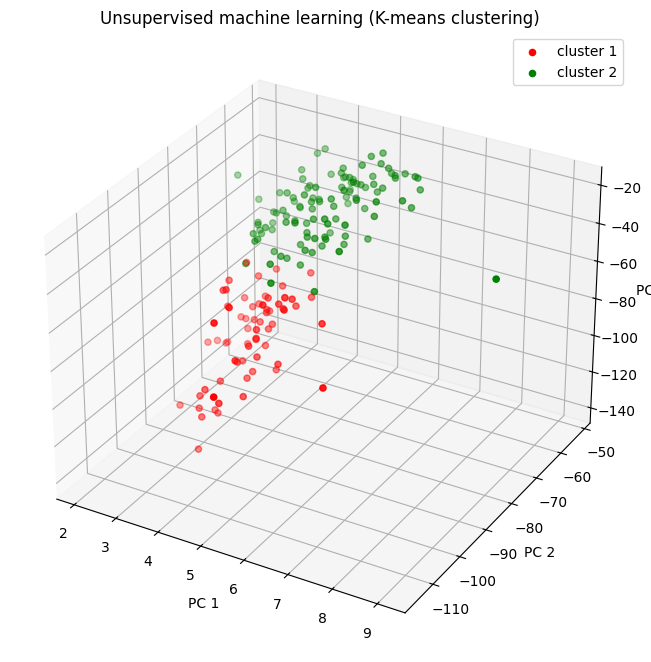

In [14]:
data_cleaning = ProcessData()
standard_data = data_cleaning.standadardize_data()
cov_matrix = data_cleaning.compute_covariance_matrix(standardized_data=standard_data)
principal_comps, pca_df = data_cleaning.Compute_principal_components(cov_matrix=cov_matrix)

classifier = Clustering(dataframe=pca_df, principal_components_array=principal_comps)
clusters = classifier.Optimize_clusters()
print(clusters)
plotter = Plotting_clusters(clusters = clusters)



#datasets


In [15]:
df=pd.read_csv('wine_data.csv')
sns.pairplot(df)

# plt.scatter(df['Alcohol'], df['Malic_Acid'], color = 'maroon')

In [ ]:
# showing the dataset
print(df)

In [ ]:
cols = list(df.columns)


# convert data into a matrix

In [ ]:
original_data = df.to_numpy()
print(original_data)

#standardize the data so that mean = 0 and standard deviation std = 1

In [ ]:
data_with_mean_0 = original_data - original_data.mean()
data_with_std_1 = data_with_mean_0 / original_data.std()
standardized_data = data_with_std_1
standardized_df = pd.DataFrame(standardized_data, columns=cols)

In [ ]:
standardized_df

In [ ]:
standardized_data.shape

In [ ]:
each_feature_mean = standardized_df.mean()
each_feature_mean

#covariance matrix computation step by step

In [ ]:

for index, col in enumerate(cols):
    standardized_df[col] -= each_feature_mean[index]

In [ ]:
standardized_df

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
multiplied = pd.DataFrame()
for col in cols:
    for j, COL in enumerate(cols):
        if j != len(cols):
            multiplied[col + " " + cols[j]] = standardized_df[col] * standardized_df[cols[j]]
multiplied

In [ ]:
print(multiplied.columns)
print(len(list(multiplied.columns))/ 13)

In [ ]:
sums = multiplied.sum()
c = [i for i in range(0, len(sums), 13)]

Covariance_matrix = []
for i, index in enumerate(c):
    try:
        Covariance_matrix.append(list(sums[index:c[i+1]]))
    except IndexError: 
        Covariance_matrix.append(list(sums[index:]))

covariance_df = pd.DataFrame(Covariance_matrix, columns=cols, index = cols)
print(covariance_df)

In [ ]:
cov_matrix = np.array(Covariance_matrix)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
eigenvalues_eugenvectors = {eigenvalue:eigenvectors[index] for index, eigenvalue in enumerate(eigenvalues)}
eigenvalues.sort()
# CHOOSE ONLY TOP 3 MAXIMUM EIGENVALUES AND GET THEIR EIGENVECTORS
max_3_eigenvectors = eigenvalues[::-1][:3]
eigenvectors_of_top_3_eigenvalues = np.array([eigenvalues_eugenvectors[eigen] for eigen in max_3_eigenvectors])

print(eigenvectors_of_top_3_eigenvalues)


#compute reduce dimension of our datasets by projecting them onto the weight matrix made of eigenvectors with top 3 maximum eigen values

In [ ]:
eigenvectors_of_top_3_eigenvalues = np.transpose(eigenvectors_of_top_3_eigenvalues)
reduced_dimension_wine_dataset = np.dot(original_data, eigenvectors_of_top_3_eigenvalues)
print(reduced_dimension_wine_dataset)

In [ ]:
sns.pairplot(pd.DataFrame(reduced_dimension_wine_dataset))

In [ ]:
final_df = pd.DataFrame(reduced_dimension_wine_dataset, columns = ['Principal comp1', 'Principal comp2', 'Principal comp3'])
ax1 = final_df.plot(kind = 'scatter', x = 'Principal comp1', y = 'Principal comp2', color = 'pink')
ax2 = final_df.plot(kind = 'scatter', x = 'Principal comp1', y = 'Principal comp3', color = 'black')
ax3 = final_df.plot(kind = 'scatter', x = 'Principal comp2', y = 'Principal comp3', color = 'green')

#classification using unsupervised machine learning algorithm called K-means clustering

In [ ]:
from random import choice
clusters = 2
clusters_data = [[],[]]
centroids = [[],[]]
k1_initial_centroids = (choice(final_df['Principal comp1']), choice(final_df['Principal comp2']), choice(final_df['Principal comp3']))
k2_initial_centroids = (choice(final_df['Principal comp1']), choice(final_df['Principal comp2']), choice(final_df['Principal comp3']))

def Generate_clusters(k1_mean=k1_initial_centroids, k2_mean = k2_initial_centroids):
    # FIRST CLEAR THE CLUSTERS TO PREPARE THEM FOR RECEIVING NEW DATA
    clusters_data[0].clear()
    clusters_data[1].clear()
    
    # COMPUTE THE EUCLEDIAN DISTANCES
    variance1 = (reduced_dimension_wine_dataset - np.array(k1_mean)) ** 2
    variance2 = (reduced_dimension_wine_dataset - np.array(k2_mean)) ** 2
    eucledian_distances1 = np.sqrt(np.array([sum(row) for row in variance1]))
    eucledian_distances2 = np.sqrt(np.array([sum(row) for row in variance2]))
    combined = zip(eucledian_distances1, eucledian_distances2)

    for index, j in enumerate(combined):
        # CLASSIFY THE DATA INTO ITS CLUSTER BASED ON THE ONE WITH THE SMALLEST EUCLIDEAN DISTANCE
        clusters_data[j.index(min(j))].append(list(reduced_dimension_wine_dataset[index]))
        
    centroids[0].append(np.mean(np.array(clusters_data[0]), axis = 0))
    centroids[1].append(np.mean(np.array(clusters_data[1]), axis = 0))
    return k1_mean, k2_mean


In [ ]:
epochs = 10
for i in range(epochs):
    if len(centroids[0]) > 0 and len(centroids[1]) > 0:
        Generate_clusters(k1_mean=centroids[0][-1], k2_mean=centroids[1][-1])
        if sum(centroids[0][-2]) - sum(centroids[0][-1]) <= 0.01 and sum(centroids[0][-2]) - sum(centroids[0][-1]) <= 0.01:
            print(f"OPTIMAL CENTROID ACHIEVED AT {i+1}/{epochs} EPOCH")
            print(f"OPTIMAL CENTROIDS: [CLUSTER 1] {centroids[0][-1]}")
            print(f"OPTIMAL CENTROIDS: [CLUSTER 2] {centroids[1][-1]}")
            break
    else:
        Generate_clusters()
    
    # print(f"EPOCH {i+1}/{epochs}")

OPTIMAL CENTROID ACHIEVED AT 3/10 EPOCH
OPTIMAL CENTROIDS: [CLUSTER 1] [  3.80225184 -86.78589079 -96.96961262]
OPTIMAL CENTROIDS: [CLUSTER 2] [  4.37486424 -68.43321866 -45.57431862]


#compute for new centroids to find the optimal ones that we need for our predictions


In [ ]:
centroids

#plot clusters in 3D

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
x_cluster1, y_cluster1, z_cluster1 = zip(*clusters_data[0])
x_cluster2, y_cluster2, z_cluster2 = zip(*clusters_data[1])

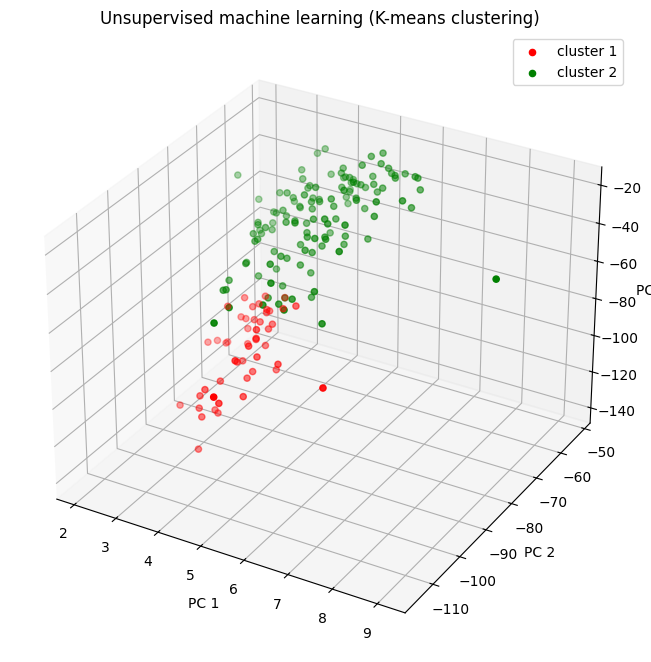

In [ ]:
fig = plt.figure(figsize=(8, 9))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x_cluster1, y_cluster1, z_cluster1, color = 'red', label = 'cluster 1')
ax.scatter(x_cluster2, y_cluster2, z_cluster2, color = 'green', label = 'cluster 2')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.title('Unsupervised machine learning (K-means clustering)')
plt.legend()

# Display the plot
plt.show()
